## Sampler template

This notebook contains the basic syntax required to run a chain. We set up a mock data object, construct an emulator and likelihood object, and pass these to a sampler to run for a small number of steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from cup1d.data import data_MPGADGET
from cup1d.likelihood import likelihood
from cup1d.likelihood import emcee_sampler

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                sim_label=test_sim_label,
                                zmax=z_max)

### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# Set up emulator training set
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)

In [5]:
# Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
kmax_Mpc=8
emu_type="polyfit"
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.50 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [6]:
#free_param_limits=[[1.1e-09, 3.19e-09], [0.89, 1.05],[-0.2, 0.2]]
#free_param_names=["As","ns","ln_tau_0"]
free_param_limits=[[1.1e-09, 3.19e-09], [0.89, 1.05],[-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2]]
free_param_names=["As","ns","ln_tau_0","ln_tau_1","ln_tau_2"]
#free_param_names=["As","ns","ln_sigT_kms_0","ln_sigT_kms_1","ln_sigT_kms_2"]
prior=0.5

In [7]:
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            free_param_limits=free_param_limits,
                            prior_Gauss_rms=prior)

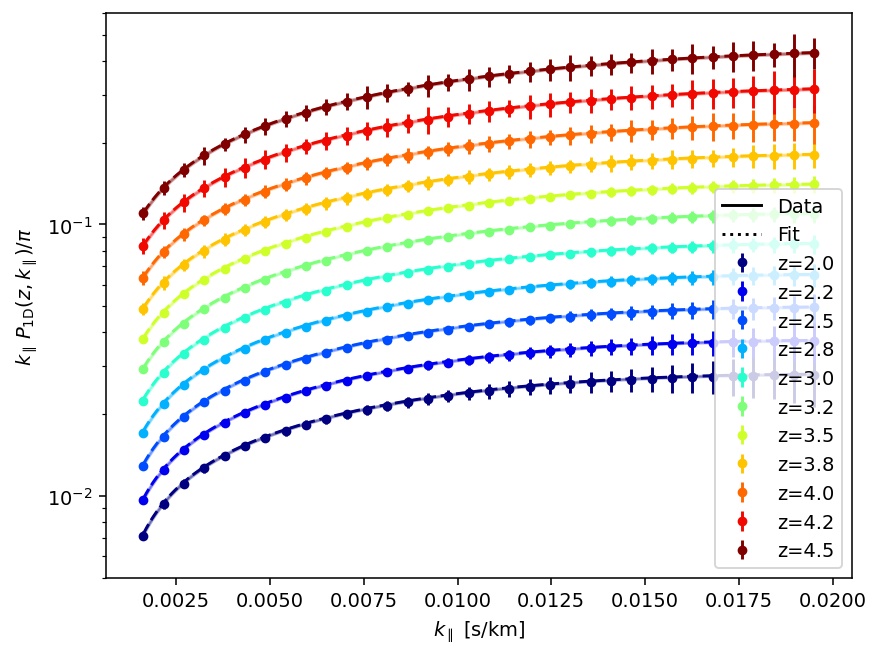

In [8]:
like.plot_p1d(residuals=False)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [9]:
# Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,verbose=False,
                        nwalkers=10,
                        save_chain=True, ## Small test run, don't create a save folder
                        progress=True)

Created directory: /global/cfs/cdirs/desi/users/font/Codes/cup1d//emcee_chains//chain_16


In [10]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

As 2.1e-09 1.1e-09 3.19e-09
ns 0.965 0.89 1.05
ln_tau_0 0.0 -0.2 0.2
ln_tau_1 0.0 -0.2 0.2
ln_tau_2 0.0 -0.2 0.2


In [11]:
n_burn_in=50
n_steps=500 ## Max number of steps to run

start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|██████████| 550/550 [01:47<00:00,  5.13it/s]

Sampling took 107.4 seconds


did not have extra P1D likelihood
Mean values: [0.42531354096510193, 0.45721619326941265, 0.5185007036300641, 0.5009502591752, 0.453472819059729]


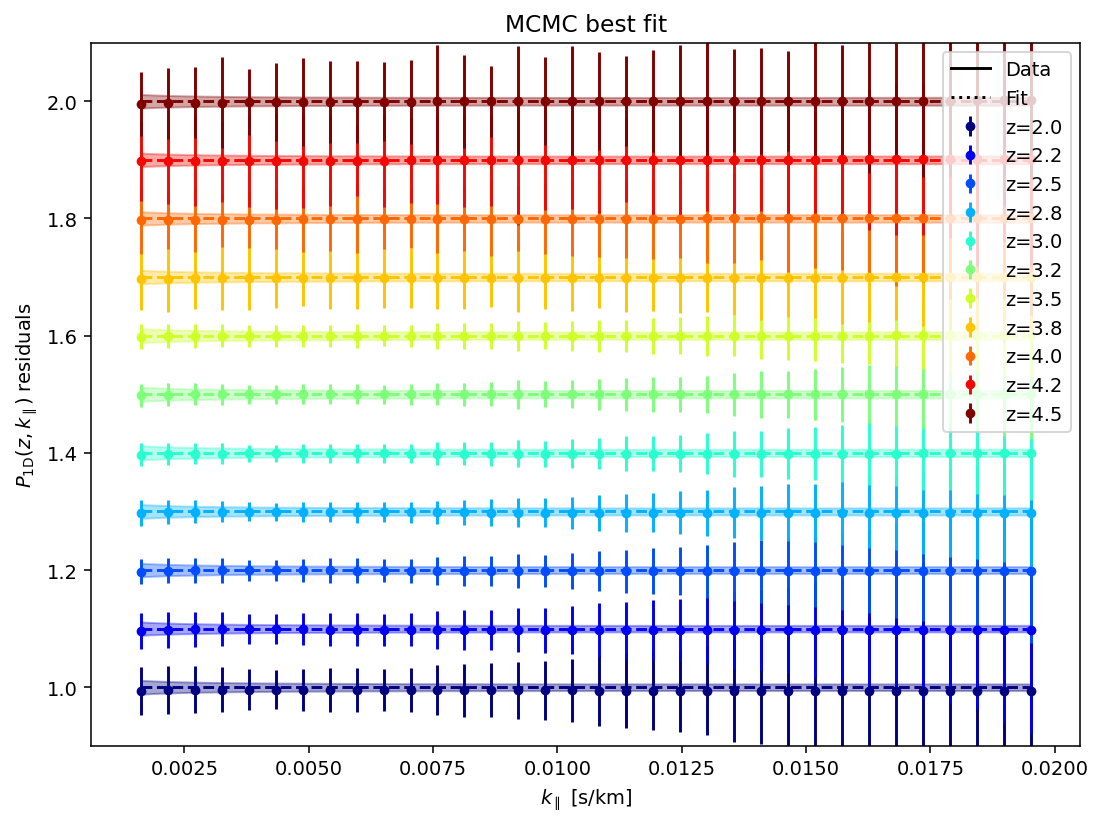

<Figure size 896x672 with 0 Axes>

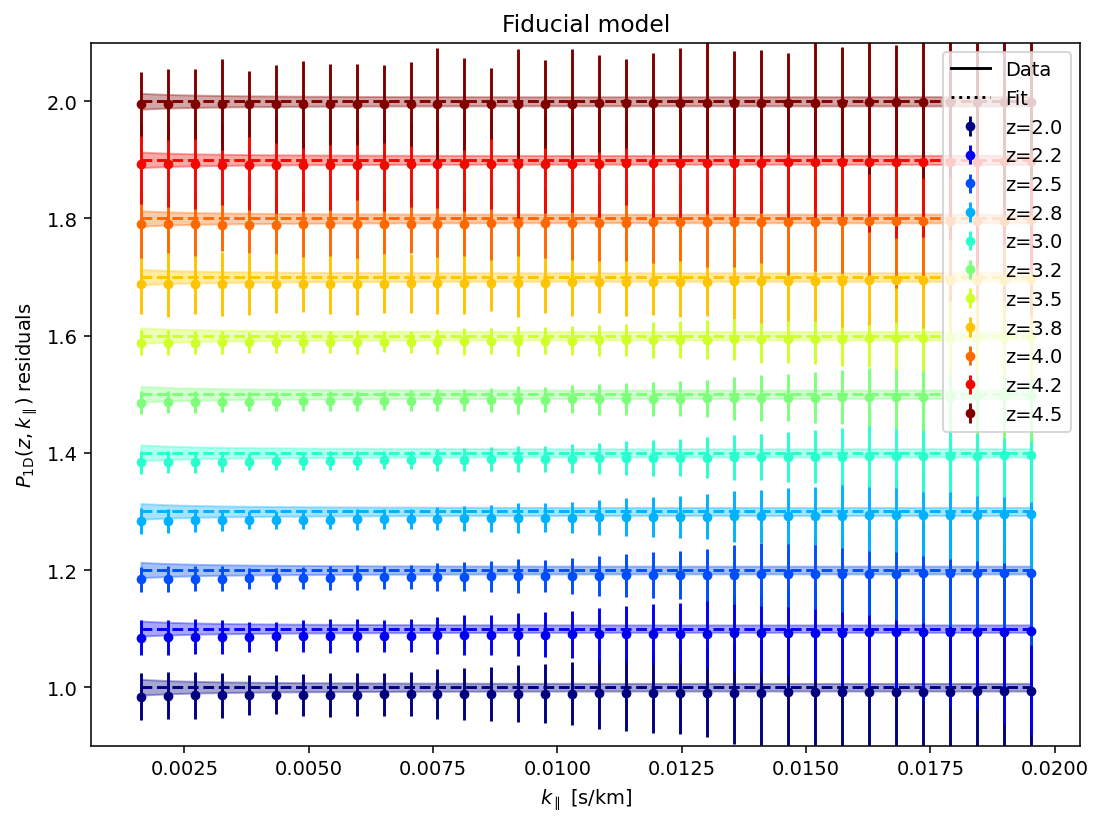

 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/chainconsumer/plotter.py:1026: UserWarning:Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/chainconsumer/plotter.py:1029: UserWarning:Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning:invalid value encountered in divide


Can't plot corner


<Figure size 896x672 with 0 Axes>

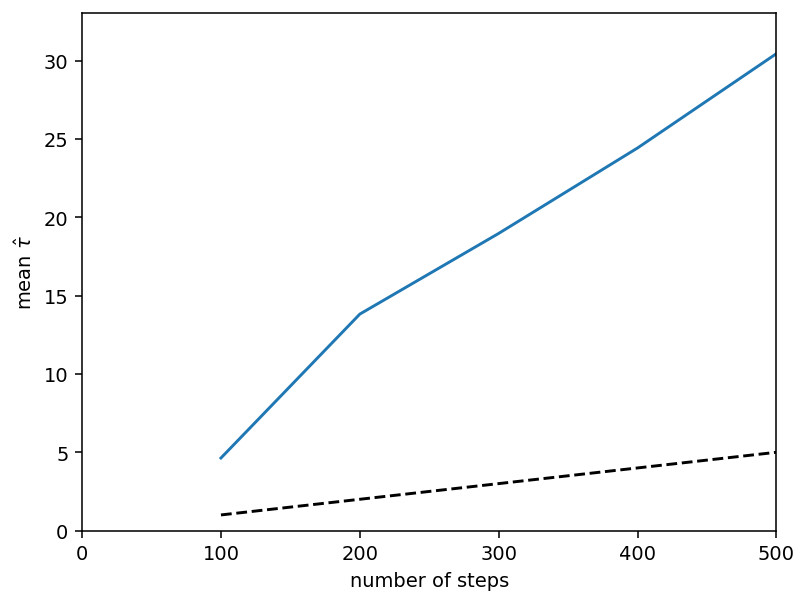

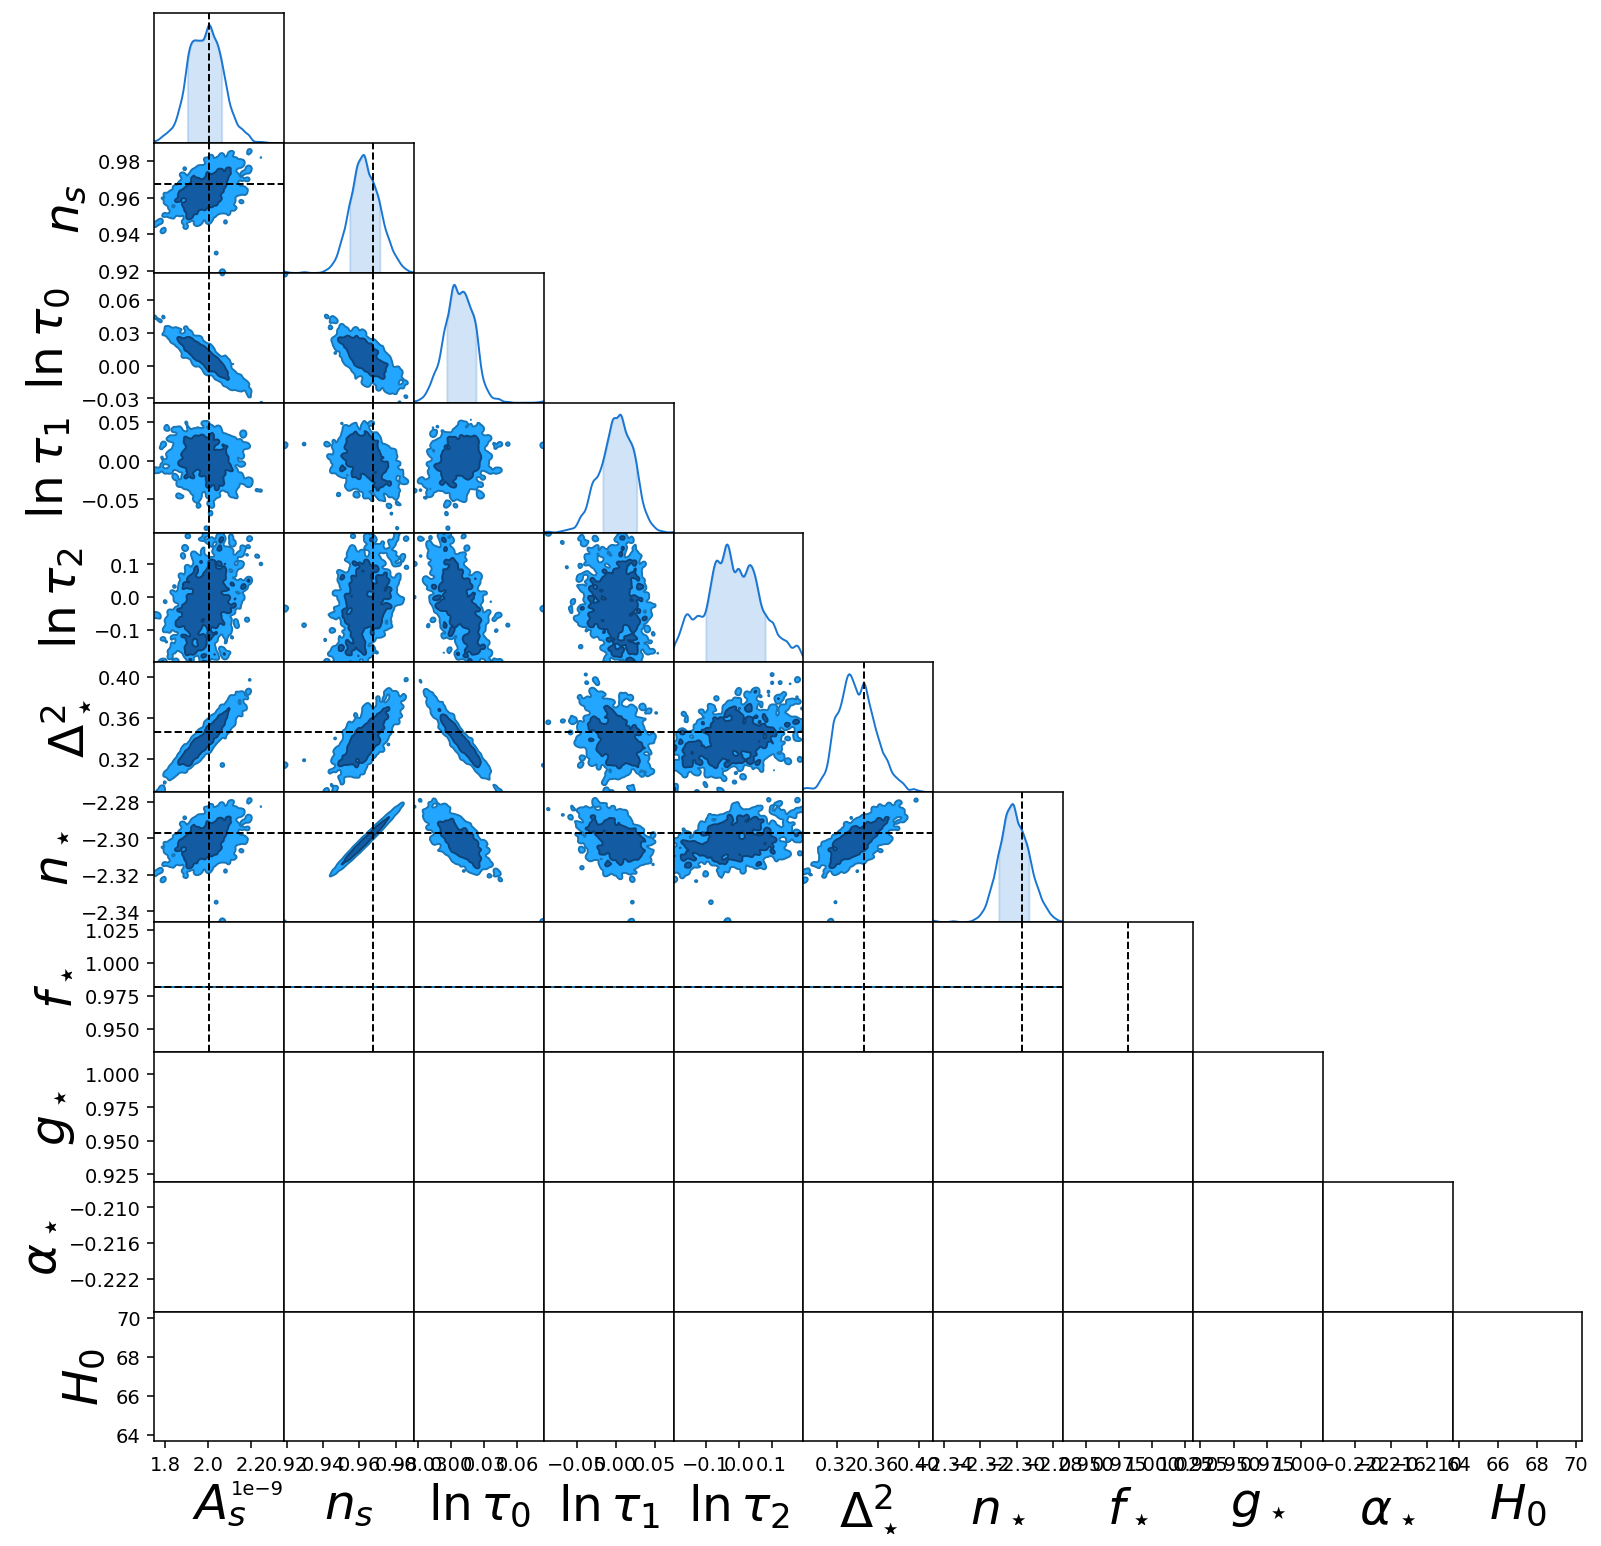

In [12]:
sampler.write_chain_to_file(residuals=True,plot_nersc=True,plot_delta_lnprob_cut=50)

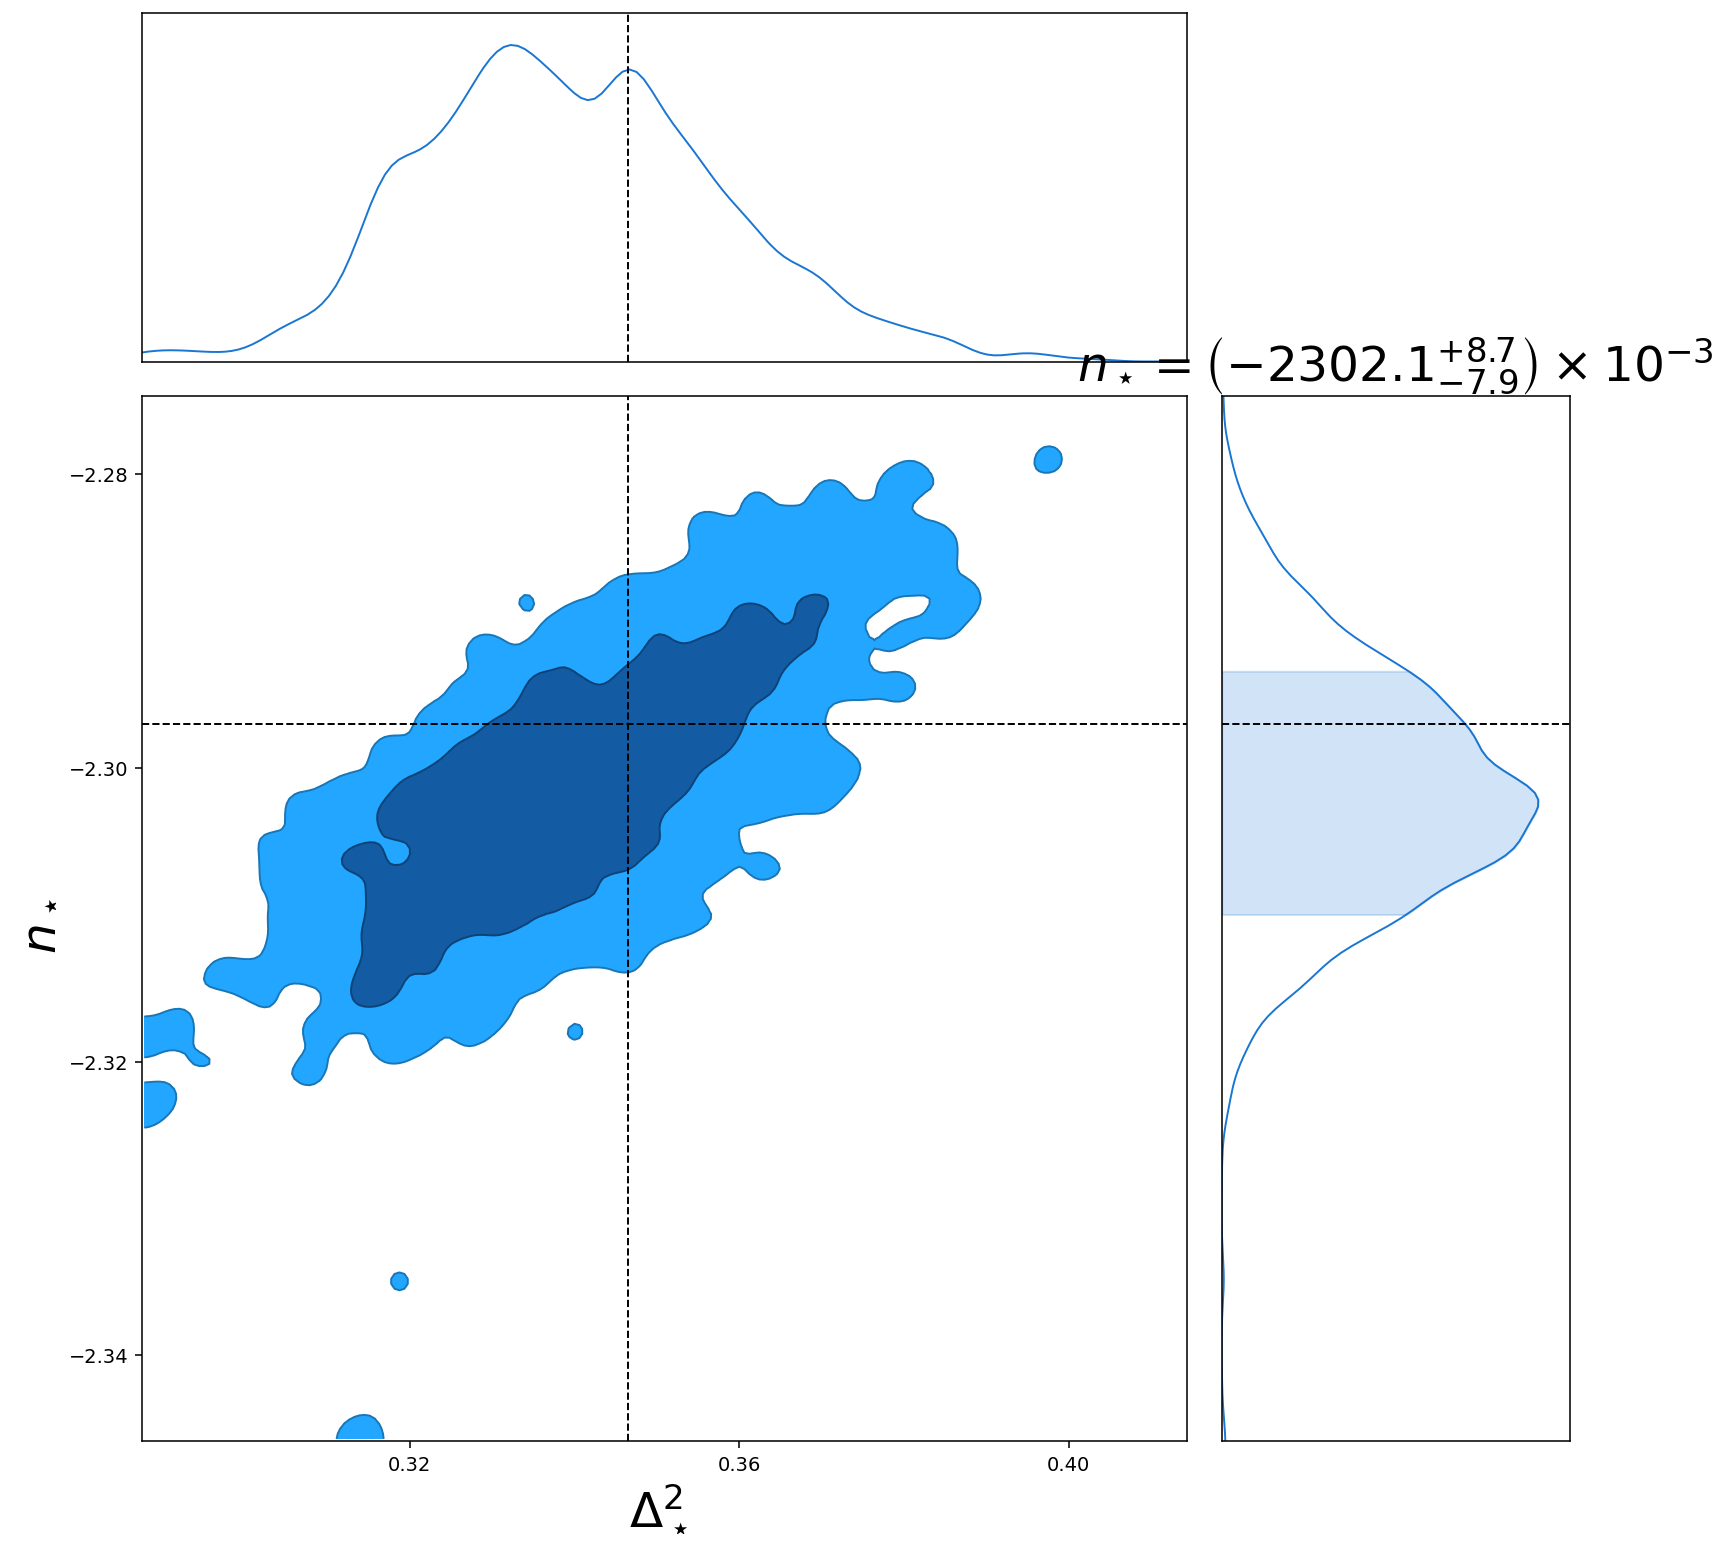

In [13]:
sampler.plot_corner(plot_params=['$\\Delta^2_\\star$','$n_\\star$'],
                    delta_lnprob_cut=50,usetex=False,serif=False)

In [14]:
a=3